<a href="https://colab.research.google.com/github/FranziskoB/Regressao_dados_contagem/blob/main/01_Regressao_dados_de_contagem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# REGRESSÃO PARA MODELOS DE CONTAGEM

Exemplo de construção de modelo de regressão em um dataset com dados de contagem. 

## Importando as bibliotecas

In [1]:
import pandas as pd # manipulação de dado em formato de dataframe
import seaborn as sns # biblioteca de visualização de informações estatísticas
import matplotlib.pyplot as plt # biblioteca de visualização de dados
import statsmodels.api as sm # biblioteca de modelagem estatística
import numpy as np # biblioteca para operações matemáticas multidimensionais
from scipy import stats
from statsmodels.iolib.summary2 import summary_col
import plotly.graph_objs as go
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

##Importação dos dados

In [2]:
df_corruption=pd.read_csv('https://raw.githubusercontent.com/FranziskoB/Regressao_dados_contagem/main/corruption.csv')

In [3]:
df_corruption.head()

,country,code,violations,staff,post,corruption
0,Angola,AGO,50,9,no,1.047506
1,Angola,AGO,1,9,yes,1.047506
2,Albania,ALB,17,3,no,0.921079
3,Albania,ALB,0,3,yes,0.921079
4,United Arab Emirates,ARE,0,3,no,-0.779468


In [4]:
df_corruption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     298 non-null    object 
 1   code        298 non-null    object 
 2   violations  298 non-null    int64  
 3   staff       298 non-null    int64  
 4   post        298 non-null    object 
 5   corruption  298 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 14.1+ KB


In [5]:
df_corruption.describe()

,violations,staff,corruption
count,298.000000,298.000000,298.000000
mean,6.496644,11.805369,0.013641
std,18.210377,11.079558,1.012474
min,0.000000,2.000000,-2.582988
25%,0.000000,6.000000,-0.415147
50%,0.000000,9.000000,0.326959
75%,3.000000,14.000000,0.720250
max,167.000000,86.000000,1.582807


In [6]:
import plotly.express as px

fig = px.histogram(df_corruption, x="violations")
fig.update_layout(
    title_text='Histograma da quantidade de violações', # title of plot
    xaxis_title_text='Violações', # xaxis label
    yaxis_title_text='Contagem', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)

fig.show()

## Análise das possíveis distribuições que melhor representam os dados

Existem dois modelos de regressão para dados de contagem:

Poisson:
* Apropriado para estimação quando a variável dependente for quantitativa e com valores inteiros e não negativos (dados de contagem) por meio da distruição de poisson com média igual à variância.

Binomial negativo:

* Apropriado para estimação quando a variável dependente for quantitativa e com valores inteiros e não negativos (dados de contagem) e quando houver superdispersão nos dados.  

## Modelo poisson

In [7]:
media_violations= df_corruption['violations'].mean()
var_violation = df_corruption['violations'].var()

In [8]:
print("O varriável dependente apresenta média igual a ",media_violations.round(2), " e variância igual ", var_violation.round(2))

O varriável dependente apresenta média igual a  6.5  e variância igual  331.62


Essa grande diferença entre média e variância indica que o modelo binomial negativo pode ser uma melhor opção em relação ao modelo de poisson. Indicios de super disperção dos dados. 

### Estimando o modelo

In [9]:
modelo_poisson = smf.glm(formula='violations ~ staff + post + corruption', data=df_corruption,
                         family=sm.families.Poisson()).fit()

In [10]:
#Parâmetros do modelo
modelo_poisson.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             violations   No. Observations:                  298
Model:                            GLM   Df Residuals:                      294
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2071.8
Date:                Sat, 01 Apr 2023   Deviance:                       3644.0
Time:                        17:48:40   Pearson chi2:                 6.77e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9999
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.2127      0.031     71.134      0.000       2.152       2.274
post[T.yes]    -4.2968      0.197    -21.762      0.000      -4.684      -3.910
staff           0.0219      0.001     17.807      0.000       0.019       0.024
corruption      0.3418      0.027     12.430      0.000       0.288       0.396
===============================================================================
"""

## TESTE DE SUPERDISPERSÃO DE CAMERON E TRIVEDI (1990)

Verificar a existência de superdisperção no dados

1º Passo: estimar um modelo Poisson;

In [11]:
df_corruption['lambda_poisson'] = modelo_poisson.predict()


In [12]:
df_corruption.head()

,country,code,violations,staff,post,corruption,lambda_poisson
0,Angola,AGO,50,9,no,1.047506,15.919915
1,Angola,AGO,1,9,yes,1.047506,0.216711
2,Albania,ALB,17,3,no,0.921079,13.371720
3,Albania,ALB,0,3,yes,0.921079,0.182023
4,United Arab Emirates,ARE,0,3,no,-0.779468,7.477915


2º Passo: criar uma nova variável (Y*) utilizando os fitted values do modelo Poisson estimado anteriormente

In [13]:
df_corruption['ystar']=(((df_corruption['violations']-df_corruption['lambda_poisson'])*(df_corruption['violations']-df_corruption['lambda_poisson']))-df_corruption['violations'])/df_corruption['lambda_poisson']

In [14]:
df_corruption.head()

,country,code,violations,staff,post,corruption,lambda_poisson,ystar
0,Angola,AGO,50,9,no,1.047506,15.919915,69.815208
1,Angola,AGO,1,9,yes,1.047506,0.216711,-1.783289
2,Albania,ALB,17,3,no,0.921079,13.371720,-0.286843
3,Albania,ALB,0,3,yes,0.921079,0.182023,0.182023
4,United Arab Emirates,ARE,0,3,no,-0.779468,7.477915,7.477915


3º Passo: estimar um modelo auxiliar OLS, com a variável Y* como variável
dependente, os fitted values do modelo Poisson como única variável preditora e 
sem o intercepto;

In [15]:
modelo_auxiliar = sm.OLS.from_formula("ystar ~ 0 + lambda_poisson", df_corruption).fit()

In [16]:
modelo_auxiliar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  ystar   R-squared (uncentered):                   0.025
Model:                            OLS   Adj. R-squared (uncentered):              0.022
Method:                 Least Squares   F-statistic:                              7.584
Date:                Sat, 01 Apr 2023   Prob (F-statistic):                     0.00625
Time:                        17:48:41   Log-Likelihood:                         -1952.9
No. Observations:                 298   AIC:                                      3908.
Df Residuals:                     297   BIC:                                      3911.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
lambda_poisson     2.6525      0.963      2.754      0.006       0.757       4.548
==============================================================================
Omnibus:                      607.263   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           446004.649
Skew:                          13.265   Prob(JB):                         0.00
Kurtosis:                     190.659   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Caso o p-value do parâmetro do lambda_poisson seja maior que 0.05,
verifica-se a existência de equidispersão nos dados.
Caso contrário, diagnostica-se a existência de superdispersão nos dados, fato
que favorecerá a estimação de um modelo binomial negativo.

###Elaboração direta do teste de superdispersão

Função 'overdisp'
Instalação e carregamento da função 'overdisp' do pacote 'statstests.tests'
Autores do pacote: Luiz Paulo Fávero e Helder Prado Santos
https://stats-tests.github.io/statstests/


In [25]:
!pip install statstests
from statstests.tests import overdisp
overdisp(modelo_poisson, df_corruption)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Estimating model...: 
 GLM
                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.022    
Dependent Variable:     ystar            AIC:                         3907.7809
Date:                   2023-04-01 17:50 BIC:                         3911.4780
No. Observations:       298              Log-Likelihood:              -1952.9  
Df Model:               1                F-statistic:                 7.584    
Df Residuals:           297              Prob (F-statistic):          0.00625  
R-squared (uncentered): 0.025            Scale:                       28915.   
-------------------------------------------------------------------------------------
            Coef.        Std.Err.         t          P>|t|        [0.025       0.975]
-------------------------------------------------------------------------------------


### Predições

Apenas para fins didáticos, caso considerássemos a estimação Poisson como a
mais adequada, qual seria a quantidade média esperada de violações de trânsito
para um país cujo corpo diplomático fosse composto por 23 membros, considerando
o período anterior à vigência da lei e cujo índice de corrupção seja
igual a 0.5?

In [17]:
modelo_poisson.predict(pd.DataFrame({'staff':[23], 'post':['no'], 'corruption':[0.5]}))

0    17.93284
dtype: float64

Qual seria a quantidade média esperada de violações de trânsito para o mesmo
país, porém agora considerando a vigência da lei?

In [18]:
modelo_poisson.predict(pd.DataFrame({'staff':[23], 'post':['yes'], 'corruption':[0.5]}))

0    0.244112
dtype: float64

##ESTIMAÇÃO DO MODELO BINOMIAL NEGATIVO

In [19]:
modelo_binom_neg = smf.glm(formula='violations ~ staff + post + corruption', data=df_corruption,
                         family=sm.families.NegativeBinomial()).fit()

In [20]:
modelo_binom_neg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             violations   No. Observations:                  298
Model:                            GLM   Df Residuals:                      294
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -589.97
Date:                Sat, 01 Apr 2023   Deviance:                       390.95
Time:                        17:48:41   Pearson chi2:                     811.
No. Iterations:                    18   Pseudo R-squ. (CS):             0.8548
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.9711      0.116     16.935      0.000       1.743       2.199
post[T.yes]    -4.2867      0.234    -18.310      0.000      -4.746      -3.828
staff           0.0382      0.006      5.885      0.000       0.025       0.051
corruption      0.4444      0.085      5.232      0.000       0.278       0.611
===============================================================================
"""

Comparando os parâmetros e os valores de LL de modelo_poisson e modelo_binom_neg

In [21]:
modelo_binom_neg.llf #Binomial negativo

-589.9739880194734

In [22]:
modelo_poisson.llf # Poisson

-2071.7937527648537

Modelo binomial apresentou valor bem mais alto indicando ser um modelo que se ajusta melhor aos dados

### Realizando predições 

COMPARAÇÕES ENTRE AS PREVISÕES:

Qual seria a quantidade média esperada de violações de trânsito para um país
cujo corpo diplomático seja composto por 23 membros, considerando o período
anterior à vigência da lei e cujo índice de corrupção seja igual 0.5?

In [23]:
modelo_poisson.predict(pd.DataFrame({'staff':[23], 'post':['no'], 'corruption':[0.5]}))

0    17.93284
dtype: float64

In [24]:
modelo_binom_neg.predict(pd.DataFrame({'staff':[23], 'post':['no'], 'corruption':[0.5]}))

0    21.586739
dtype: float64

## Modelos Inflacionados de Zeros

São considerados uma combinação entre um modelo para dados de contagem e um modelo para
dados binários, já que são utilizados para investigar as razões que levam a determinada quantidade de
ocorrências (contagens) de um fenômeno, bem como as razões que levam (ou não) à ocorrência
propriamente dita deste fenômeno, independentemente da quantidade de contagens observadas.
Enquanto um modelo Poisson inflacionado de zeros é estimado a partir da combinação de uma
distribuição Bernoulli com uma distribuição Poisson, um modelo binomial negativo inflacionado de
zeros é estimado por meio da combinação de uma distribuição Bernoulli com uma distribuição
Poisson-Gama.

LAMBERT, D. Zero-inflated Poisson regression, with an application to defects in manufacturing.
Technometrics, v. 34, n. 1, p. 1-14, 1992.


### Modelos Inflacionados de Zeros do Tipo Poisson (ZIP)

In [27]:

y = df_corruption.violations #Definição da variável dependente (voltando ao dataset 'df_corruption')
x1 = df_corruption[['staff','post','corruption']]#Definição das variáveis preditoras que entrarão no componente de contagem
X1 = sm.add_constant(x1)
x2 = df_corruption[['corruption']]#Definição das variáveis preditoras que entrarão no componente logit (inflate)
X2 = sm.add_constant(x2)
#Se estimarmos o modelo sem dummizar as variáveis categórias, o modelo retorna
#um erro
X1 = pd.get_dummies(X1, columns=['post'], drop_first=True)#Se estimarmos o modelo sem dummizar as variáveis categórias, o modelo retorna um erro



Estimação do modelo ZIP pela função 'ZeroInflatedPoisson' do pacote
'Statsmodels'

Estimação do modelo ZIP
O argumento 'exog_infl' corresponde às variáveis que entram no componente
logit (inflate)


In [28]:
modelo_zip = sm.ZeroInflatedPoisson(y, X1, exog_infl=X2,
                                    inflation='logit').fit()

Optimization terminated successfully.
         Current function value: 5.977545
         Iterations: 22
         Function evaluations: 27
         Gradient evaluations: 27


In [29]:
#Parâmetros do modelo
modelo_zip.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:              violations   No. Observations:                  298
Model:             ZeroInflatedPoisson   Df Residuals:                      294
Method:                            MLE   Df Model:                            3
Date:                 Sat, 01 Apr 2023   Pseudo R-squ.:                  0.1975
Time:                         17:58:00   Log-Likelihood:                -1781.3
converged:                        True   LL-Null:                       -2219.8
Covariance Type:             nonrobust   LLR p-value:                8.828e-190
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
inflate_const         -1.6116      0.240     -6.714      0.000      -2.082      -1.141
inflate_corruption    -0.9523      0.195     -4.875      0.000      -1.335      -0.569
const                  2.4889      0.032     78.990      0.000       2.427       2.551
staff                  0.0200      0.001     16.154      0.000       0.018       0.022
corruption             0.0937      0.030      3.127      0.002       0.035       0.152
post_yes              -4.2879      0.201    -21.291      0.000      -4.683      -3.893
======================================================================================
"""

Gráfico para comparar os valores previstos x valores reais de
 'violations' pelo modelo ZIP

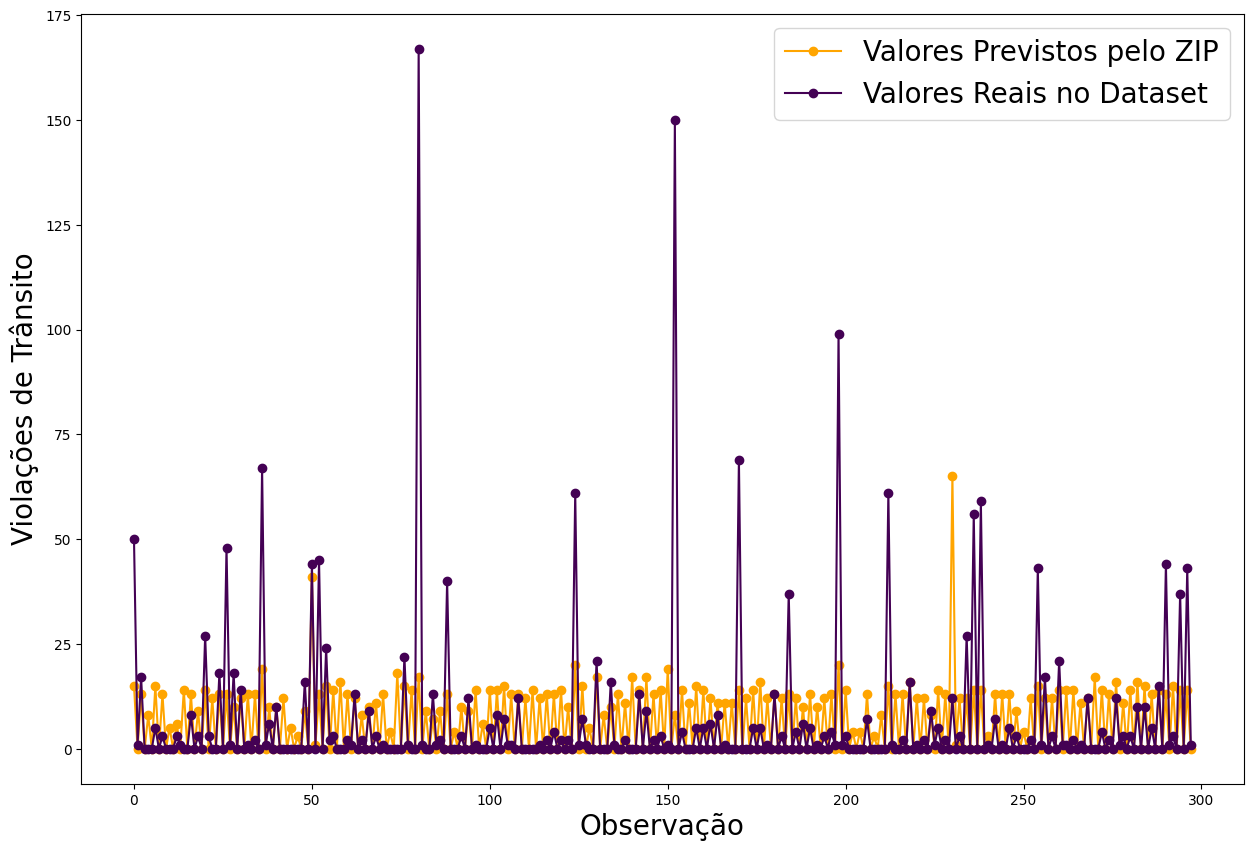

In [30]:
zip_predictions = modelo_zip.predict(X1, exog_infl=X2)
predicted_counts = np.round(zip_predictions)
actual_counts = df_corruption['violations']

plt.figure(figsize=(15,10))
plt.plot(df_corruption.index, predicted_counts, 'go-',
         color='orange')
plt.plot(df_corruption.index, actual_counts, 'go-',
         color='#440154FF')
plt.xlabel('Observação', fontsize=20)
plt.ylabel('Violações de Trânsito', fontsize=20)
plt.legend(['Valores Previstos pelo ZIP', 'Valores Reais no Dataset'],
           fontsize=20)
plt.show()

## Comparando os modelos Poisson e ZIP

In [31]:
summary_col([modelo_poisson, modelo_zip], 
            model_names=["Poisson","ZIP"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf),
                'Pseudo-R2':lambda x: "{:.4f}".format(x.pseudo_rsquared()),
        })


,Poisson,ZIP
Intercept,2.2127***,
,(0.0311),
const,,2.4889***
,,(0.0315)
corruption,0.3418***,0.0937***
,(0.0275),(0.0300)
inflate_const,,-1.6116***
,,(0.2401)
inflate_corruption,,-0.9523***
,,(0.1954)


likelihood ratio test para comparação de LL's entre modelos

In [33]:
#Definição da função 'lrtest'
def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llnull
    llk_2 = modelo_1.llf
    
    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 1)
    return round(LR_statistic,2), round(p_val,2)


In [34]:
lrtest([modelo_poisson, modelo_zip])

(580.97, 0.0)

O teste likelihood mostrou que os LL's entre o modelo poisson e ZIP são estatísticamente diferentes 

Gráfico para a comparação dos LL dos modelos Poisson, BNeg e ZIP

Text(0.5, 0, 'Log-Likehood')

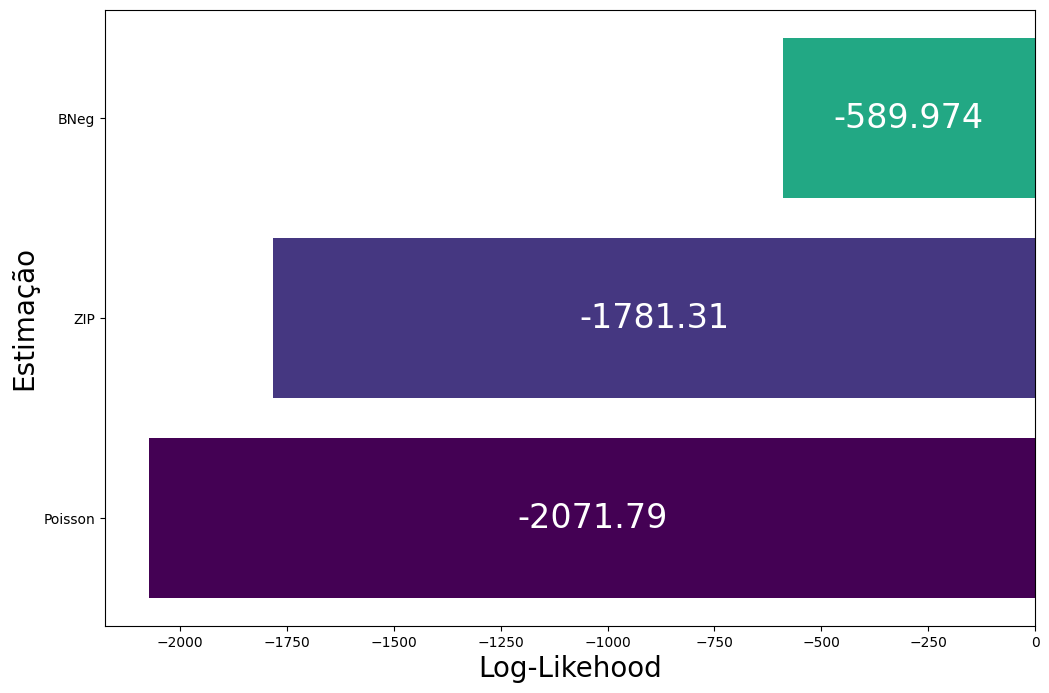

In [37]:
#Definição do dataframe com os modelos e respectivos LL
df_llf = pd.DataFrame({'modelo':['Poisson','ZIP','BNeg'],
                      'loglik':[modelo_poisson.llf,
                                modelo_zip.llf,
                                modelo_binom_neg.llf]})
df_llf

#Plotagem propriamente dita
fig, ax = plt.subplots(figsize=(12,8))

c = ["#440154FF", "#453781FF", "#22A884FF"]

ax1 = ax.barh(df_llf.modelo, df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=24)
ax.set_ylabel("Estimação", fontsize=20)
ax.set_xlabel("Log-Likehood", fontsize=20)


### COMPARAÇÕES ENTRE AS PREVISÕES:

Supondo que considerássemos a estimação ZIP como a mais adequada, qual seria a 
quantidade média esperada de violações de trânsito para um país cujo corpo 
diplomático seja composto por 23 membros, considerando o período anterior à 
vigência da lei e cujo índice de corrupção seja igual a 0.5?

In [38]:
#Modelo Poisson:
modelo_poisson.predict(pd.DataFrame({'staff':[23],
                                     'post':['no'],
                                     'corruption':[0.5]}))

0    17.93284
dtype: float64

In [39]:
#Modelo binomial negativo:
modelo_binom_neg.predict(pd.DataFrame({'staff':[23],
                                  'post':['no'],
                                  'corruption':[0.5]}))

0    21.586739
dtype: float64

In [40]:
#Modelo ZIP:
#Obs.: manter a ordem dos parâmetros nos argumentos da função 'predict' modelo_zip.params
modelo_zip.predict(pd.DataFrame({'const':[1],
                                 'staff':[23],
                                 'corruption':[0.5],
                                 'post_yes':[0]}),
                   exog_infl=pd.DataFrame({'const':[1],
                                           'corruption':[0.5]}))

0    17.802404
dtype: float64

Qual seria a quantidade média esperada de violações de trânsito para o mesmo
país ao se considerar o início da vigência da lei?

In [41]:
#Modelo Poisson:
modelo_poisson.predict(pd.DataFrame({'staff':[23],
                                     'post':['yes'],
                                     'corruption':[0.5]}))

0    0.244112
dtype: float64

In [43]:
#Modelo binomial negativo:
modelo_binom_neg.predict(pd.DataFrame({'staff':[23],
                                  'post':['yes'],
                                  'corruption':[0.5]}))


0    0.296818
dtype: float64

In [44]:
#Modelo ZIP:
modelo_zip.predict(pd.DataFrame({'const':[1],
                                 'staff':[23],
                                 'corruption':[0.5],
                                 'post_yes':[1]}),
                   exog_infl=pd.DataFrame({'const':[1],
                                           'corruption':[0.5]}))


0    0.24449
dtype: float64

### ESTIMAÇÃO DO MODELO ZERO-INFLATED BINOMIAL NEGATIVO (ZINB)  

In [45]:
y = df_corruption.violations #Definição da variável dependente (voltando ao dataset 'df_corruption')
x1 = df_corruption[['staff','post','corruption']]#Definição das variáveis preditoras que entrarão no componente de contagem
X1 = sm.add_constant(x1)
x2 = df_corruption[['corruption']]#Definição das variáveis preditoras que entrarão no componente logit (inflate)
X2 = sm.add_constant(x2)

#Se estimarmos o modelo sem dummizar as variáveis categórias, o modelo retorna
#um erro
X1 = pd.get_dummies(X1, columns=['post'], drop_first=True)

In [46]:
#Estimação do modelo ZINB pela função 'ZeroInflatedNegativeBinomialP' do
#pacote 'statsmodels.discrete.count_model'

from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP

#Estimação do modelo ZINB
#O argumento 'exog_infl' corresponde às variáveis que entram no componente
#logit (inflate)
modelo_zinb = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X2,
                                            inflation='logit').fit()

         Current function value: 1.870015
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39


In [47]:
#Parâmetros do modelo
modelo_zinb.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                        violations   No. Observations:                  298
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                      294
Method:                                      MLE   Df Model:                            3
Date:                           Sat, 01 Apr 2023   Pseudo R-squ.:                  0.1700
Time:                                   18:45:06   Log-Likelihood:                -557.26
converged:                                 False   LL-Null:                       -671.37
Covariance Type:                       nonrobust   LLR p-value:                 3.353e-49
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
inflate_const        -17.9857      9.287     -1.937      0.053     -36.187       0.216
inflate_corruption    -8.1104      4.037     -2.009      0.045     -16.023      -0.197
const                  2.0324      0.203      9.988      0.000       1.634       2.431
staff                  0.0411      0.013      3.078      0.002       0.015       0.067
corruption             0.1815      0.147      1.237      0.216      -0.106       0.469
post_yes              -4.2638      0.261    -16.328      0.000      -4.776      -3.752
alpha                  1.8560      0.218      8.518      0.000       1.429       2.283
======================================================================================
"""

O parâmetro 'alpha' apresentado é o inverso do parâmetro 'theta', ou seja,
o inverso do parâmetro de forma da distribuição Poisson-Gama.
Como 'alpha' (e da mesma forma 'theta') é estatisticamente diferente de
zero, podemos afirmar que há superdispersão nos dados (outra forma de
verificar o fenômeno da superdispersão!)

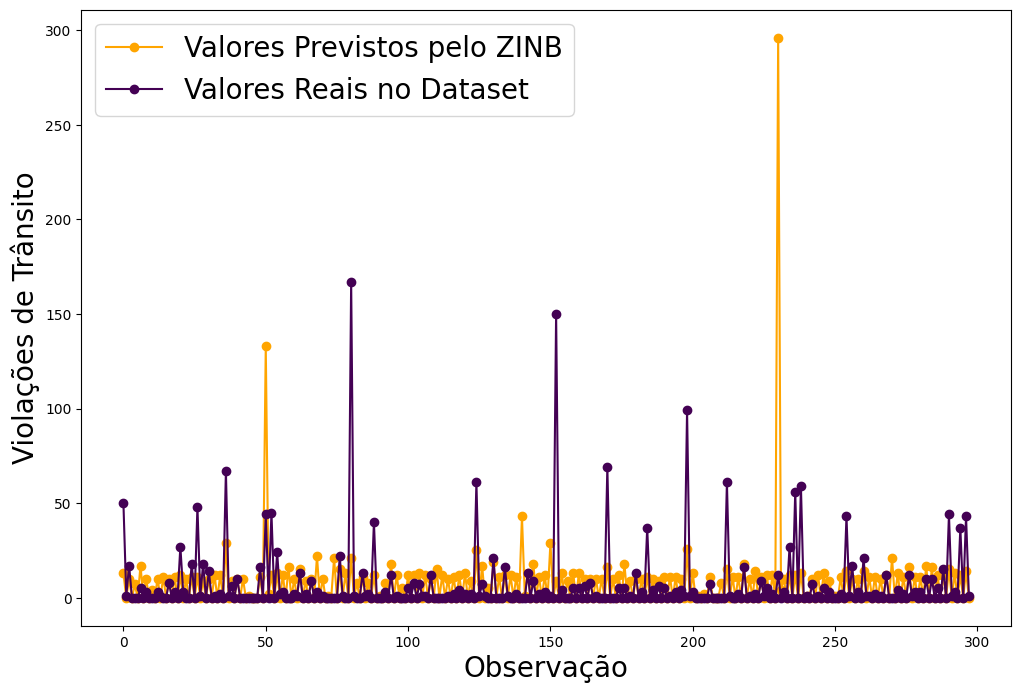

In [49]:
# Gráfico para comparar os valores previstos x valores reais de
#'violations' pelo modelo ZINB
zinb_predictions = modelo_zinb.predict(X1, exog_infl=X2)
predicted_counts = np.round(zinb_predictions)
actual_counts = df_corruption['violations']
plt.figure(figsize=(12,8))
plt.plot(df_corruption.index, predicted_counts, 'go-',
         color='orange')
plt.plot(df_corruption.index, actual_counts, 'go-',
         color='#440154FF')
plt.xlabel('Observação', fontsize=20)
plt.ylabel('Violações de Trânsito', fontsize=20)
plt.legend(['Valores Previstos pelo ZINB', 'Valores Reais no Dataset'],
           fontsize=20)
plt.show()

### Comparando os modelos BNeg e ZINB

In [51]:
summary_col([modelo_binom_neg, modelo_zinb], 
            model_names=["BNeg","ZINB"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf),
                'Pseudo-R2':lambda x: "{:.4f}".format(x.pseudo_rsquared()),
        })


,BNeg,ZINB
Intercept,1.9711***,
,(0.1164),
alpha,,1.8560***
,,(0.2179)
const,,2.0324***
,,(0.2035)
corruption,0.4444***,0.1815
,(0.0849),(0.1466)
inflate_const,,-17.9857*
,,(9.2867)


 likelihood ratio test para comparação de LL's entre modelos

In [53]:
lrtest([modelo_binom_neg, modelo_zinb])

(65.42, 0.0)

Gráfico para a comparação dos LL dos modelos Poisson, BNeg, ZIP e ZINB

In [56]:
df_llf = pd.DataFrame({'modelo':['Poisson','ZIP','BNeg','ZINB'],
                      'loglik':[modelo_poisson.llf,
                                modelo_zip.llf,
                                modelo_binom_neg.llf,
                                modelo_zinb.llf]})
df_llf

,modelo,loglik
0,Poisson,-2071.793753
1,ZIP,-1781.308425
2,BNeg,-589.973988
3,ZINB,-557.264368


Plotagem propriamente dita

Text(0.5, 0, 'Log-Likehood')

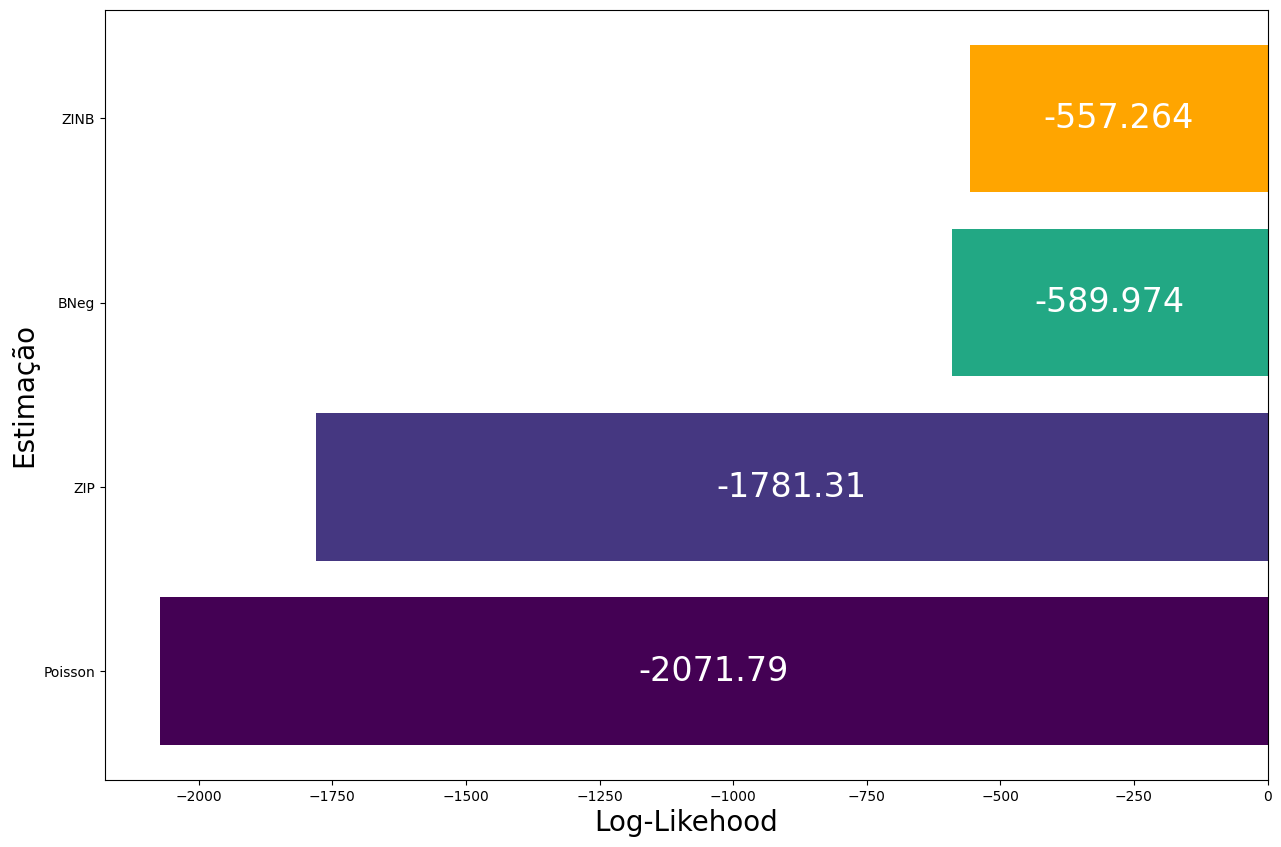

In [57]:
fig, ax = plt.subplots(figsize=(15,10))

c = ["#440154FF", "#453781FF", "#22A884FF", "orange"]

ax1 = ax.barh(df_llf.modelo, df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=24)
ax.set_ylabel("Estimação", fontsize=20)
ax.set_xlabel("Log-Likehood", fontsize=20)


####  COMPARAÇÕES ENTRE AS PREVISÕES:
Supondo que considerássemos a estimação ZINB como a mais adequada, qual seria
a quantidade média esperada de violações de trânsito para um país cujo corpo 
vigência da lei e cujo índice de corrupção seja igual a 0.5?

In [58]:
#Modelo ZINB:
#Obs.: manter a ordem dos parâmetros nos argumentos da função 'predict'
modelo_zinb.params
modelo_zinb.predict(pd.DataFrame({'const':[1],
                                  'staff':[23],
                                  'corruption':[0.5],
                                  'post_yes':[0]}),
                    exog_infl=pd.DataFrame({'const':[1],
                                            'corruption':[0.5]}))

0    21.495939
dtype: float64

Qual seria a quantidade média esperada de violações de trânsito para o mesmo
país, porém agora considerando a vigência da lei?

In [59]:
#Modelo ZINB:
modelo_zinb.predict(pd.DataFrame({'const':[1],
                                  'staff':[23],
                                  'corruption':[0.5],
                                  'post_yes':[1]}),
                    exog_infl=pd.DataFrame({'const':[1],
                                            'corruption':[0.5]}))

0    0.302422
dtype: float64

## Gráfico de comparação de fitted values dos 4 modelos desenvolvidos

In [62]:
# In[ ]: Adicionando os fitted values dos modelos estimados para fins de
#comparação
df_corruption['fitted_zip'] = modelo_zip.predict(X1, exog_infl=X2)
df_corruption['fitted_zinb'] = modelo_zinb.predict(X1, exog_infl=X2)
df_corruption['fitted_poisson'] = modelo_poisson.fittedvalues
df_corruption['fitted_bneg'] = modelo_binom_neg.fittedvalues

df_corruption.head()


,country,code,violations,staff,post,corruption,lambda_poisson,ystar,fitted_zip,fitted_zinb,fitted_poisson,fitted_bneg
0,Angola,AGO,50,9,no,1.047506,15.919915,69.815208,14.823562,13.358543,15.919915,16.126548
1,Angola,AGO,1,9,yes,1.047506,0.216711,-1.783289,0.203580,0.187939,0.216711,0.221740
2,Albania,ALB,17,3,no,0.921079,13.371720,-0.286843,12.877979,10.203814,13.371720,12.122094
3,Albania,ALB,0,3,yes,0.921079,0.182023,0.182023,0.176860,0.143555,0.182023,0.166679
4,United Arab Emirates,ARE,0,3,no,-0.779468,7.477915,7.477915,8.379367,7.494531,7.477915,5.693394


Fitted values dos modelos POISSON, BNEG, ZIP e ZINB, considerando,
para fins didáticos, a variável dependente 'violations' em função apenas da
variável preditora 'staff'



<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 2000x1000 with 0 Axes>

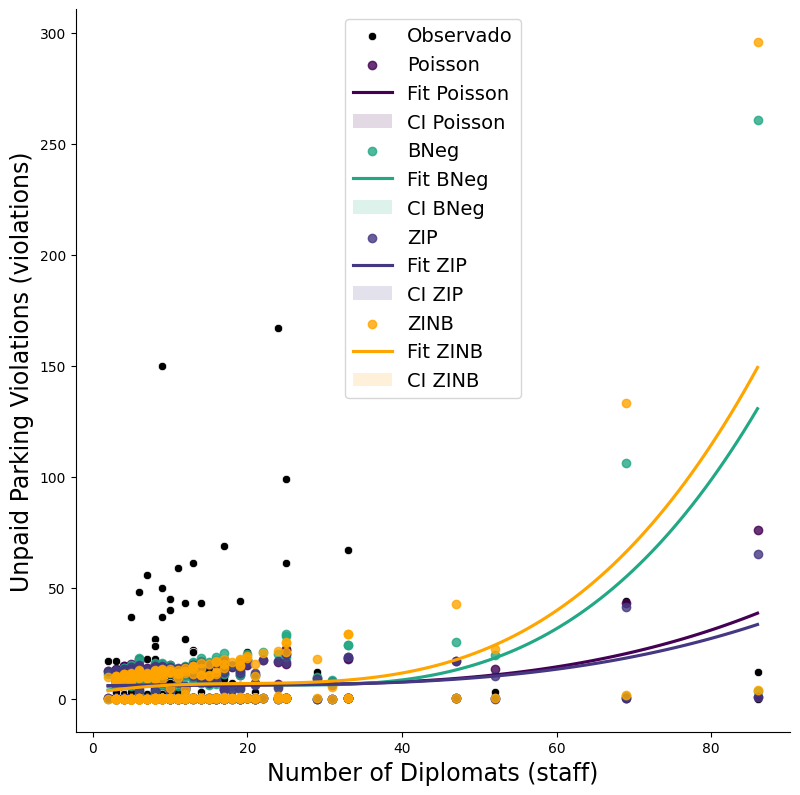

In [69]:
plt.figure(figsize=(20,10))
sns.relplot(data=df_corruption, x='staff', y='violations',
           color='black', height=8)
sns.regplot(data=df_corruption, x='staff', y='fitted_poisson', order=3,
            color='#440154FF',ci=False)
sns.regplot(data=df_corruption, x='staff', y='fitted_bneg', order=3,
            color='#22A884FF',ci=False)
sns.regplot(data=df_corruption, x='staff', y='fitted_zip', order=3,
            color='#453781FF',ci=False)
sns.regplot(data=df_corruption, x='staff', y='fitted_zinb', order=3,
            color='orange',ci=False)
plt.xlabel('Number of Diplomats (staff)', fontsize=17)
plt.ylabel('Unpaid Parking Violations (violations)', fontsize=17)
plt.legend(['Observado', 'Poisson', 'Fit Poisson', 'CI Poisson',
            'BNeg', 'Fit BNeg', 'CI BNeg',
            'ZIP', 'Fit ZIP', 'CI ZIP',
            'ZINB', 'Fit ZINB', 'CI ZINB'],
           fontsize=14)
plt.show

## Conclusão
O modelo ZIMB apresentou o maior LL's portando foi o melhor modelo encontrado para representar a base de dados